In [1]:
import tensorflow as tf
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from IPython.display import clear_output

In [2]:
path = Path.cwd() / 'datasets' / 'BankChurners.csv'
df = pd.read_csv(path)
df = df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])
df['Attrition_Flag'] = df['Attrition_Flag'].astype(str)
df['Attrition_Flag'] = df['Attrition_Flag'].str.replace('Existing Customer', '0')
df['Attrition_Flag'] = df['Attrition_Flag'].str.replace('Attrited Customer', '1')
df['Attrition_Flag'] = df['Attrition_Flag'].astype(int)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag                int32
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [4]:
#nan check
nans = df.columns[df.isna().any()].tolist()
print(nans)

[]


In [5]:
df_num = df.select_dtypes(exclude=['object'])
df_string = df.select_dtypes(include=['object'])

In [6]:
df_onehot = pd.get_dummies(df_string)
cdf = pd.concat([df_num, df_onehot], axis=1)

In [7]:
rand = np.random.rand(len(df)) < 0.8
xtrain = cdf[rand]
xtest = cdf[~rand]
ytrain = xtrain.pop('Attrition_Flag')
ytest = xtest.pop('Attrition_Flag')

In [8]:
feature_columns = []
columns = list(cdf.columns)
for feature_name in columns:
    if feature_name != 'Attrition_Flag':
        feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
# print("")
# print(feature_columns)

NUM_EXAMPLES = len(ytrain)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X),y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

train_input_fn = make_input_fn(xtrain, ytrain)
eval_input_fn = make_input_fn(xtest, ytest, shuffle=False, n_epochs=1)

In [9]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

linear_est.train(train_input_fn, max_steps=100)

result = linear_est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                8.343080e-01
accuracy_baseline       8.343080e-01
auc                     5.000000e-01
auc_precision_recall    1.656920e-01
average_loss            4.135873e+06
label/mean              1.656920e-01
loss                    4.135873e+06
precision               0.000000e+00
prediction/mean         0.000000e+00
recall                  0.000000e+00
global_step             1.000000e+02
dtype: float64


In [10]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)

est.train(train_input_fn, max_steps=100)

result = est.evaluate(eval_input_fn)

clear_output()
print(pd.Series(result))

accuracy                  0.969298
accuracy_baseline         0.834308
auc                       0.990963
auc_precision_recall      0.957874
average_loss              0.094595
label/mean                0.165692
loss                      0.094595
precision                 0.926154
prediction/mean           0.163998
recall                    0.885294
global_step             100.000000
dtype: float64


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\josephdavis\AppData\Local\Temp\tmp0m0h1emd\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


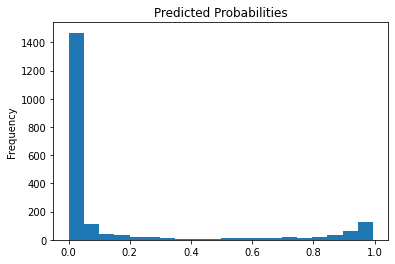

In [13]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='Predicted Probabilities')
plt.show()